In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spatialdata_io
import spatialdata as sd
import sys 
# while not pip installable, add path to file 
sys.path.append("../..")
import exrna 


In [2]:
xenium_path_cropped='/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr'
output_path='/media/sergio/Discovair_final/analysis_crop'
sdata=sd.read_zarr(xenium_path_cropped)

/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argum

# 1. Filtering extracellular reads

In [ ]:
sdata=exrna.pp.define_extracellular(sdata, min_prop_of_extracellular=0.8) 
#### WORK: this will not filter out stuff, just add a column defining intracellular vs extracellular
#adapt it for different types of filters, add layers

/home/sergio/Jnotebooks/exRNA/spatial_exotranscriptomics/notebooks/spatial_data_tutorials/../../exrna/pp/compute.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby('feature_name').count()
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [ ]:
### work a bit into better functions for plotting here
plot_data=sdata.points['transcripts'][['segmentation_free_clusters','overlaps_cell','overlaps_nucleus']].compute()
plot_crosstab(plot_data,xvar='segmentation_free_clusters',yvar='overlaps_cell',normalize=True,axis=1,kind='bar',figsize=(20,7),figures_path=output_path,stacked=True,cmap='coolwarm',sortby=True)
plot_crosstab(plot_data,xvar='segmentation_free_clusters',yvar='overlaps_nucleus',normalize=True,axis=1,kind='bar',figsize=(20,7),figures_path=output_path,stacked=True,cmap='coolwarm',sortby=1)


input_data=sdata.points['transcripts'][['missegmentation_associated']].compute()
exrna.pl.pie_of_positive(input_data,groupby='missegmentation_associated',figures_path=output_path,save=True)

NameError: name 'plot_crosstab' is not defined

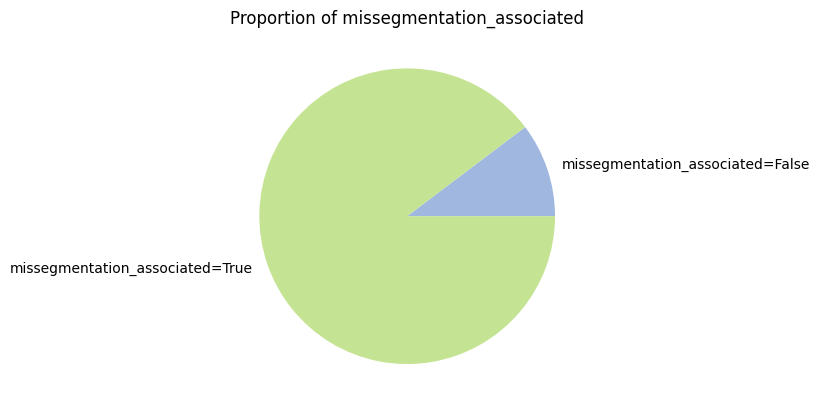

In [ ]:

input_data=sdata.points['transcripts'][['missegmentation_associated']].compute()
exrna.pl.pie_of_positive(input_data,groupby='missegmentation_associated',figures_path=output_path,save=True)

## 2. Filter genes below noise threshold

In [6]:
# First we filter data in sdata and keep only not associated with missegmentation
sdata.points['extracellular_transcripts']=sdata.points['transcripts'][sdata.points['transcripts']['missegmentation_associated'].compute()==False]

/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/dask/dataframe/core.py:4979: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meta = self._meta[_extract_meta(key)]


In [ ]:
control_codewords = ['negative_control_probe','unassigned_codeword', 'deprecated_codeword', 
                     'genomic_control_probe', 'negative_control_codeword']

sdata, scores_by_genes, noise_threshold = exrna.pp.quantify_overexpression(sdata=sdata,
    layer='extracellular_transcripts',
    codeword_column="codeword_category",
    control_codewords=scontrol_codewords,
    gene_id_column="feature_name",
    percentile_threshold=99.99)


/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `extracellular_transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


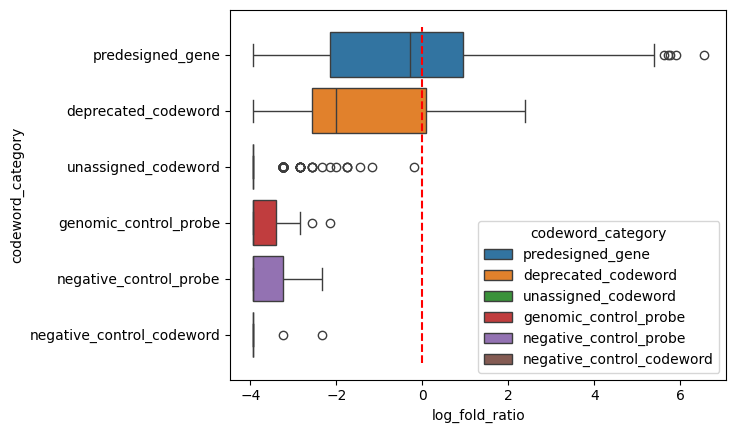

In [9]:
exrna.pl.plot_genes_over_noise(sdata, scores_by_genes, layer='extracellular_transcripts',output_path=output_path)

In [10]:
sdata.points['extracellular_transcripts_enriched']=sdata.points['extracellular_transcripts'][sdata.points['extracellular_transcripts']['log_fold_ratio'].compute()>0]

/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/dask/dataframe/core.py:4979: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meta = self._meta[_extract_meta(key)]


In [11]:
sdata

SpatialData object, with associated Zarr store: /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 5000), (5, 1500, 2500), (5, 750, 1250), (5, 375, 625), (5, 188, 312)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
│     └── 'nucleus_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
├── Points
│     ├── 'extracellular_transcripts': DataFrame with shape: (<Delayed>, 18) (3D points)
│     ├── 'extracellular_transcripts_enriched': DataFrame with shape: (<Delayed>, 18) (3D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 17) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (1762, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (1722, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (1750, 1) (2D shapes)
└── Tables
      ├── 'segmentat

/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [13]:

# format for saving
points=sdata.points['transcripts'].compute()
points['is_gene'] = points['is_gene'].astype('string')
points['overlaps_nucleus'] = points['overlaps_nucleus'].astype('float64')
points['codeword_index'] = points['codeword_index'].astype('float64')
points['transcript_id'] = points['transcript_id'].astype('float64')
points['missegmentation_associated']=points['missegmentation_associated'].astype(str)
sdata.points['transcripts']=sd.models.PointsModel.parse(points)

###format for saving
points=sdata.points['extracellular_transcripts'].compute()
points['is_gene'] = points['is_gene'].astype('string')
points['overlaps_nucleus'] = points['overlaps_nucleus'].astype('float64')
points['codeword_index'] = points['codeword_index'].astype('float64')
points['transcript_id'] = points['transcript_id'].astype('float64')
points['missegmentation_associated']=points['missegmentation_associated'].astype(str)
sdata.points['extracellular_transcripts']=sd.models.PointsModel.parse(points)

# format for saving
points=sdata.points['extracellular_transcripts_enriched'].compute()
points['is_gene'] = points['is_gene'].astype('string')
points['overlaps_nucleus'] = points['overlaps_nucleus'].astype('float64')
points['codeword_index'] = points['codeword_index'].astype('float64')
points['transcript_id'] = points['transcript_id'].astype('float64')
points['missegmentation_associated']=points['missegmentation_associated'].astype(str)
sdata.points['extracellular_transcripts_enriched']=sd.models.PointsModel.parse(points)

/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `extracellular_transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `extracellular_transcripts_enriched` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [14]:
xenium_path_cropped='/media/sergio/Ymir/extracellular_analysis/mousebrain_prime_crop_points2regions_analyzed.zarr'
sdata.write(xenium_path_cropped)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside                                                                                         
         /media/sergio/Ymir/extracellular_analysis/mousebrain_prime_crop_points2regions_analyzed.zarr). Please see 
         the documentation of `is_self_contained()` to understand the implications of working with SpatialData     
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr the new file path:                
         /media/sergio/Ymir/extracellular_analysis/mousebrain_prime_crop_points2regions_analyzed.zarr              
